# Next-Day Silver ETF Prices Prediction with LSTM

1. Importing Libraries

In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompos

2. Data Visualization Utilities

In [35]:
# function to decompose data into multiple plots
def plot_decompose(decompose_result):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 20))
    decompose_result.observed.plot(legend=False, ax=ax1, fontsize=20, grid=True, linewidth=3)
    ax1.set_ylabel("Observed", fontsize=20)
    decompose_result.trend.plot(legend=False, ax=ax2, fontsize=20, grid=True, linewidth=3)
    ax2.set_ylabel("Trend", fontsize=20)
    decompose_result.seasonal.plot(legend=False, ax=ax3, fontsize=20, grid=True, linewidth=3)
    ax3.set_ylabel("Seasonal", fontsize=20)
    decompose_result.resid.plot(legend=False, ax=ax4, fontsize=20, grid=True, linewidth=3)
    ax4.set_ylabel("Residual", fontsize=20)
    plt.tight_layout()
    plt.show()


3. Loading and Preprocessing Data

In [36]:
# Loading data
data = pd.read_csv('../input/historic-silverprices-2005-to-2023/SLV_Data.csv')
print(data)

         Date       Open       High        Low      Close  Adj Close    Volume
0      5/1/06  13.920000  14.179000  13.750000  13.870000  13.870000  14835000
1      5/2/06  14.245000  14.400000  14.100000  14.365000  14.365000  12511000
2      5/3/06  14.450000  14.464000  13.413000  13.925000  13.925000  15141000
3      5/4/06  13.950000  14.287000  13.680000  14.000000  14.000000  11075000
4      5/5/06  14.000000  14.030000  13.750000  13.995000  13.995000   6586000
...       ...        ...        ...        ...        ...        ...       ...
4371  9/12/23  21.000000  21.219999  20.969999  21.129999  21.129999   8738500
4372  9/13/23  21.010000  21.110001  20.910000  20.930000  20.930000  11886100
4373  9/14/23  20.600000  20.860001  20.450001  20.730000  20.730000  26204900
4374  9/15/23  21.190001  21.350000  21.100000  21.110001  21.110001  22799000
4375  9/18/23  21.219999  21.320000  21.049999  21.299999  21.299999  11481300

[4376 rows x 7 columns]


In [37]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

# Normalize the 'Close' column
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))


/tmp/ipykernel_32/1503893705.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])


4. Decomposiiton Plots looking at seasonality

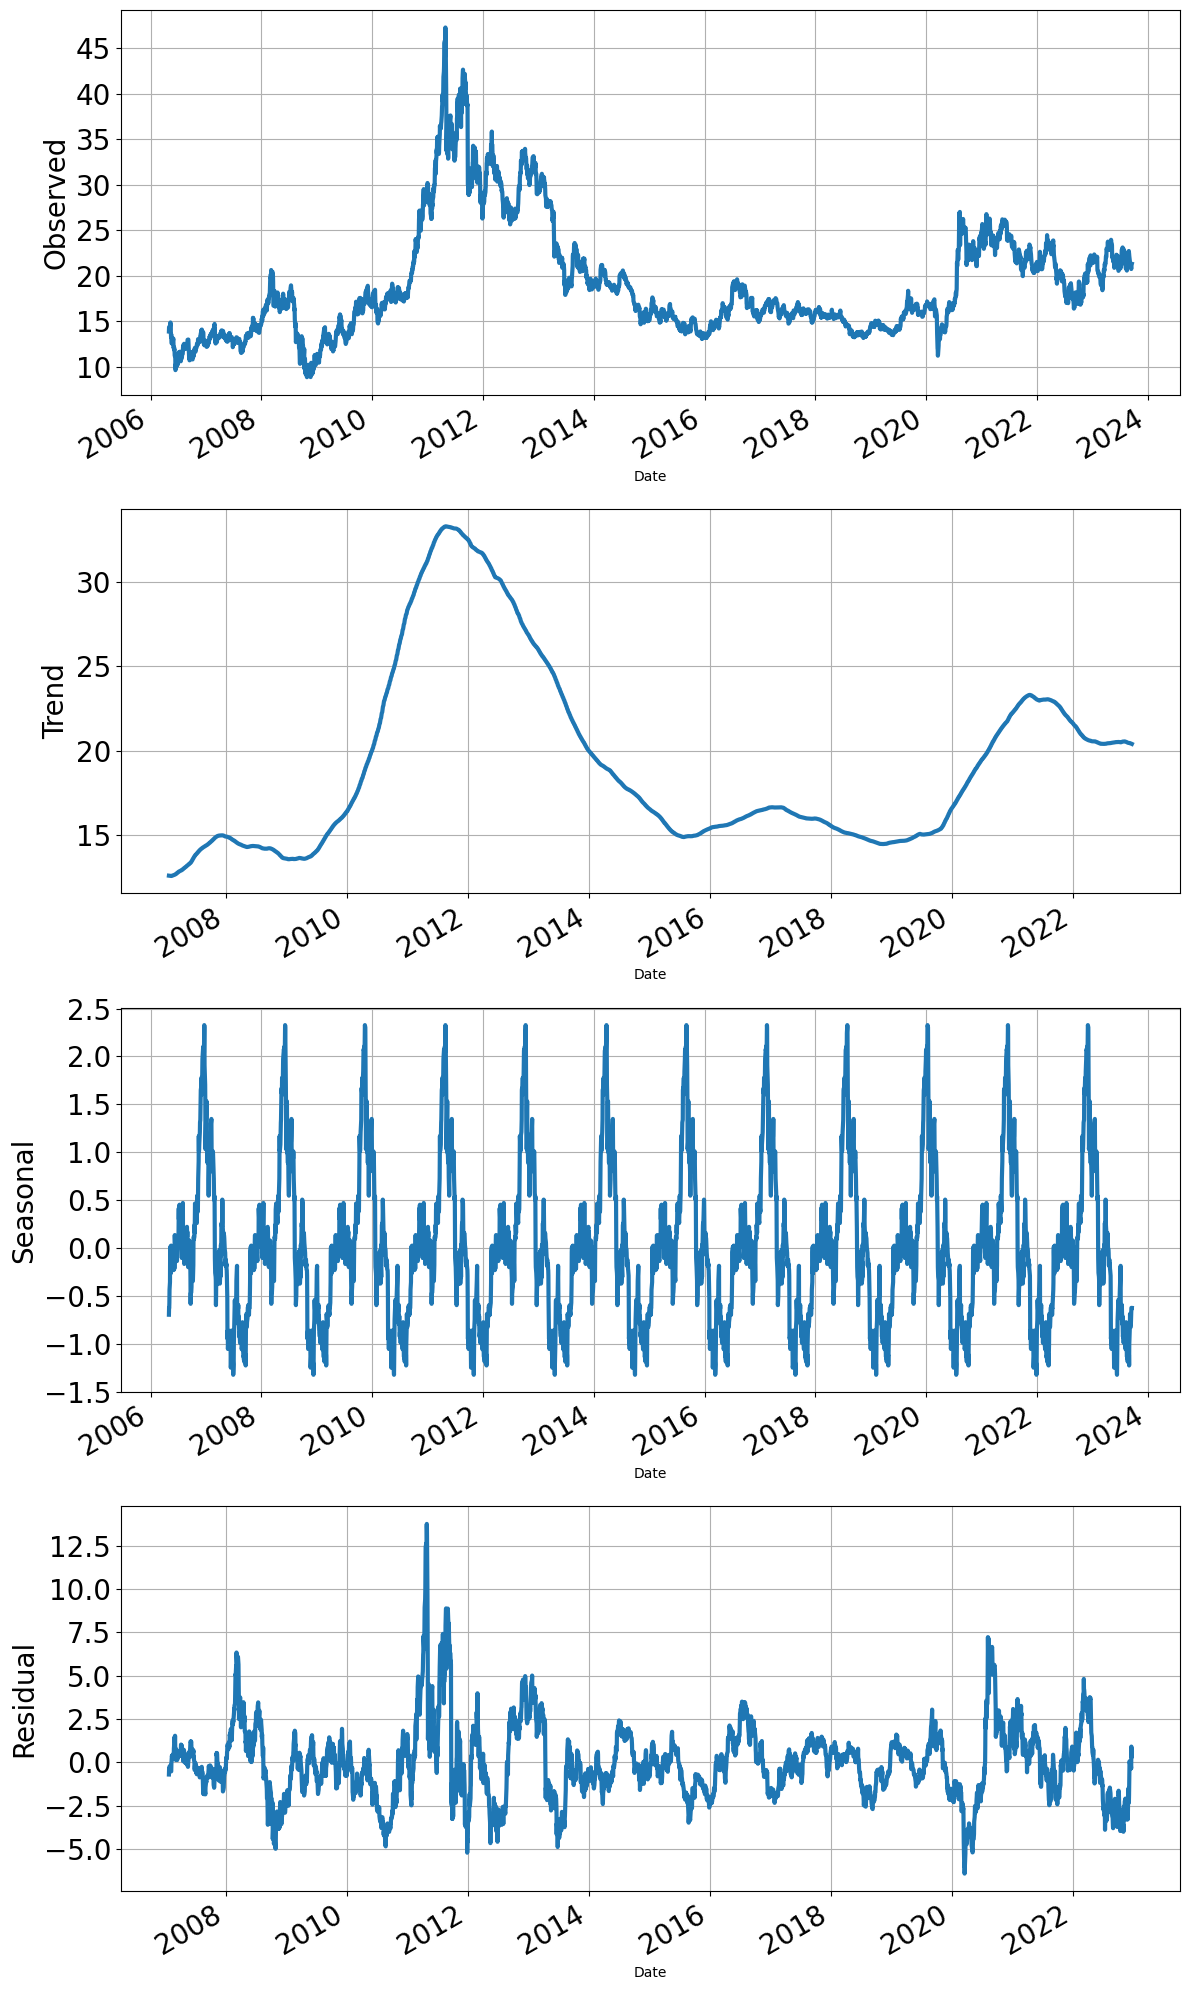

In [38]:
# Decompose the data
decomposition = seasonal_decompose(data['Close'], period=365)  
plot_decompose(decomposition)

5. Dataset preparation for LSTM

In [39]:
# datasets for LSTM
X = []
y = []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [40]:
# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

6. Building & Training LSTM Model

In [41]:
# 3. Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [42]:
# 4. Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
108/108 [==============================] - 11s 58ms/step - loss: 0.0045
Epoch 2/50
108/108 [==============================] - 6s 56ms/step - loss: 7.0016e-04
Epoch 3/50
108/108 [==============================] - 6s 57ms/step - loss: 6.8708e-04
Epoch 4/50
108/108 [==============================] - 6s 57ms/step - loss: 5.2833e-04
Epoch 5/50
108/108 [==============================] - 6s 57ms/step - loss: 4.7541e-04
Epoch 6/50
108/108 [==============================] - 6s 59ms/step - loss: 4.1162e-04
Epoch 7/50
108/108 [==============================] - 6s 58ms/step - loss: 3.8540e-04
Epoch 8/50
108/108 [==============================] - 6s 56ms/step - loss: 3.4930e-04
Epoch 9/50
108/108 [==============================] - 6s 56ms/step - loss: 3.3806e-04
Epoch 10/50
108/108 [==============================] - 6s 55ms/step - loss: 3.1344e-04
Epoch 11/50
108/108 [==============================] - 6s 57ms/step - loss: 3.2709e-04
Epoch 12/50
108/108 [==============================] - 

7. Model Evaluation and Prediction

In [44]:
#predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# MSE
mse = mean_squared_error(actual_prices, predictions)
print("Mean Squared Error:", mse)

27/27 [==============================] - 1s 18ms/step
Mean Squared Error: 0.21925260362506827


8. Visualization and Analysis of Predictions

108/108 [==============================] - 3s 18ms/step


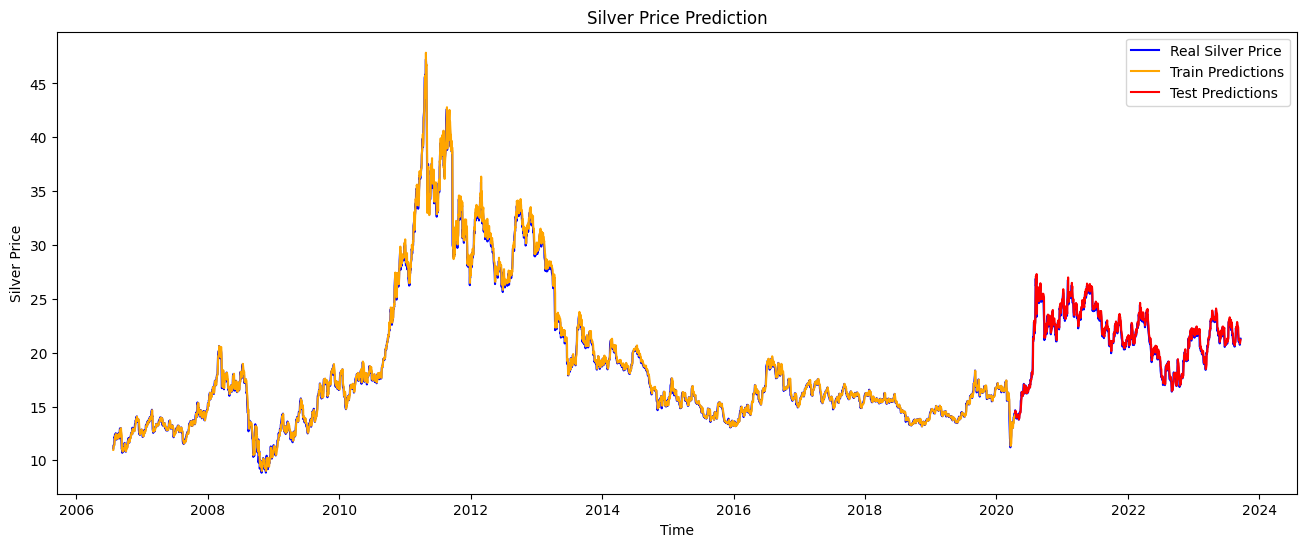

In [45]:
# training prediction data for visualization
train_predictions = model.predict(X_train)
train_predictions = scaler.inverse_transform(train_predictions)

plt.figure(figsize=(16, 6))

# Actual Prices
actual_prices = scaler.inverse_transform(y.reshape(-1, 1))  # Convert all y values back to original prices
plt.plot(data.index[60:], actual_prices, color='blue', label='Real Silver Price')

# Train Predictions
plt.plot(data.index[60:len(train_predictions)+60], train_predictions, color='orange', label='Train Predictions')

# Test Predictions
plt.plot(data.index[len(data)-len(predictions):], predictions, color='red', label='Test Predictions')

plt.title('Silver Price Prediction')
plt.xlabel('Time')
plt.ylabel('Silver Price')
plt.legend()
plt.show()


/opt/conda/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


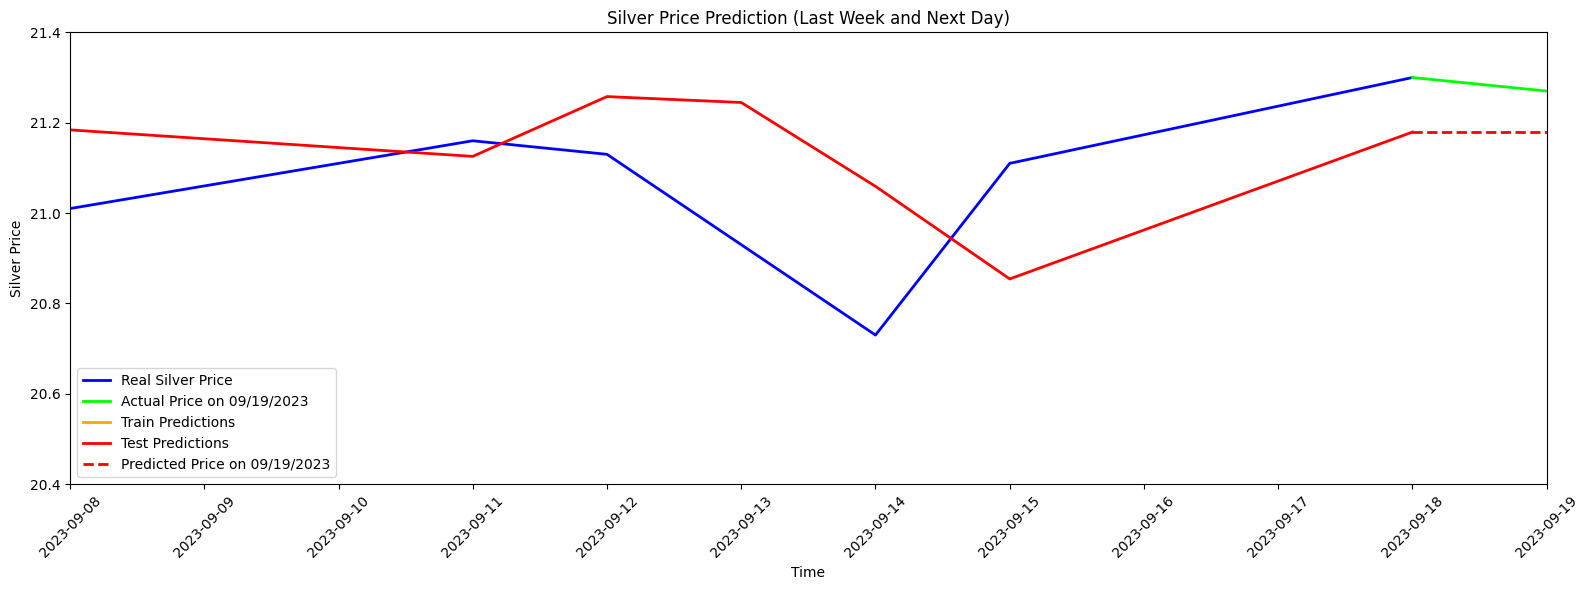

In [46]:
plt.figure(figsize=(16, 6))

#actual prices up to 09/18/2023
plt.plot(data.index[60:], actual_prices, color='blue', label='Real Silver Price', linewidth=2)

# Plot the actual price for 09/19/2023
next_date = pd.Timestamp(data.index[-1]) + pd.Timedelta(days=1) # Calculate the next date (09/19/2023)
plt.plot([data.index[-1], next_date], [actual_prices[-1], 21.27], color='lime', label='Actual Price on 09/19/2023', linewidth=2)

# Train and test predictions
plt.plot(data.index[60:len(train_predictions)+60], train_predictions, color='orange', label='Train Predictions', linewidth=2)
plt.plot(data.index[len(data)-len(predictions):], predictions, color='red', label='Test Predictions', linewidth=2)

# Predicted price for 09/19/2023
predicted_next_date_value = predictions[-1] # Assuming predictions includes the prediction for 09/19/2023
plt.plot([data.index[-1], next_date], [predictions[-1], predicted_next_date_value], color='red', linestyle='--', linewidth=2, label='Predicted Price on 09/19/2023')

plt.title('Silver Price Prediction (Last Week and Next Day)')
plt.xlabel('Time')
plt.ylabel('Silver Price')
plt.legend()

# last week (7 days) and next day prediction
plt.xlim(data.index[-7], next_date)
plt.ylim(20.4, 21.4)
plt.xticks(pd.date_range(start=data.index[-7], end=next_date, freq='D'), rotation=45)
plt.tight_layout()
plt.show()


In [47]:
n_steps = 60
n_features = 1

# Use the last n_steps values from the dataset
last_n_steps = X[-1].reshape(1, n_steps, n_features)

# Predict the next value
predicted_value = model.predict(last_n_steps)

# Inverse the scaling
predicted_value_actual = scaler.inverse_transform(predicted_value)

# Extract the scalar value
predicted_price = predicted_value_actual[0][0]


print(f"The predicted silver price for the next day,9/19/2023 is: ${predicted_value_actual[0][0]:.2f}")
print(f"The actual closing silver price for 9/19/2023 was: $21.27")
percent_difference = abs((predicted_price - 21.27) / 21.27) * 100
print(f"The percent difference between predicted and actual value is: {percent_difference:.2f}%")

1/1 [==============================] - 0s 29ms/step
The predicted silver price for the next day,9/19/2023 is: $21.18
The actual closing silver price for 9/19/2023 was: $21.27
The percent difference between predicted and actual value is: 0.43%
